Data from [Briggs et al., 2017](https://doi.org/10.7554/eLife.26945.001).

In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

2023.05.08.08


In [3]:
from scipy.stats import spearmanr
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

# Preprocessing 

In [4]:
adata1 = sc.read('/home/mffang/data/counts/Briggs/SRR5413307/counts_filtered/adata.loom')
adata1.obs['day'] = 0
adata1

AnnData object with n_obs × n_vars = 1501 × 55471
    obs: 'barcode'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

(array([ 71., 428., 394., 269., 167.,  91.,  50.,  25.,   3.,   3.]),
 array([   81. ,  1702.4,  3323.8,  4945.2,  6566.6,  8188. ,  9809.4,
        11430.8, 13052.2, 14673.6, 16295. ], dtype=float32),
 <BarContainer object of 10 artists>)

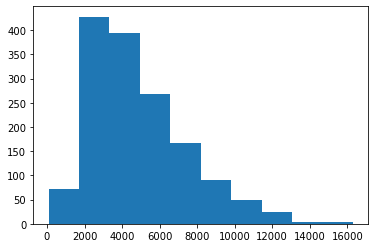

In [6]:
plt.hist(adata1.X.toarray().sum(1))

In [11]:
adata2 = sc.read('/home/mffang/data/counts/Briggs/SRR5413308/counts_filtered/adata.loom')
adata2.obs['day'] = 5
adata2

AnnData object with n_obs × n_vars = 852 × 55471
    obs: 'barcode', 'day'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

(array([ 10., 162., 221., 166., 138.,  92.,  45.,  11.,   6.,   1.]),
 array([3.0000e+00, 5.2470e+02, 1.0464e+03, 1.5681e+03, 2.0898e+03,
        2.6115e+03, 3.1332e+03, 3.6549e+03, 4.1766e+03, 4.6983e+03,
        5.2200e+03], dtype=float32),
 <BarContainer object of 10 artists>)

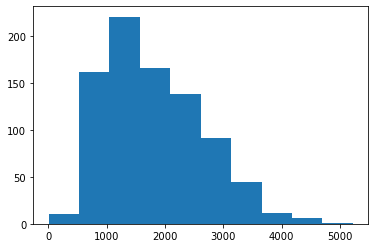

In [7]:
plt.hist(adata2.X.toarray().sum(1))

In [8]:
adata3 = sc.read('/home/mffang/data/counts/Briggs/SRR5413310/counts_filtered/adata.loom')
adata3.obs['day'] = 11
adata3

AnnData object with n_obs × n_vars = 1367 × 55471
    obs: 'barcode', 'day'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [9]:
adata4 = sc.read('/home/mffang/data/counts/Briggs/SRR5413312/counts_filtered/adata.loom')
adata4.obs['day'] = 6
adata4

AnnData object with n_obs × n_vars = 1100 × 55471
    obs: 'barcode', 'day'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [10]:
adata5 = sc.read('/home/mffang/data/counts/Briggs/SRR5413314/counts_filtered/adata.loom')
adata5.obs['day'] = 12
adata5

AnnData object with n_obs × n_vars = 1115 × 55471
    obs: 'barcode', 'day'
    var: 'gene_id', 'gene_name'
    layers: 'matrix', 'spliced', 'unspliced'

In [12]:
their_dp = pd.read_csv('/home/mffang/data/counts/Briggs/GSE97390_direct_programming.raw_umifm_counts.csv',header=None).T
their_dp

,0,1,2,3,4,5,6,7,8,9,...,28197,28198,28199,28200,28201,28202,28203,28204,28205,28206
0,Timepoint,Pass filter flag,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
1,1,1,1,0,0,0,0,4,2,0,...,97,73,28,45,8,7,33,0,8,1
2,1,1,1,0,0,1,1,6,0,0,...,73,71,24,39,7,8,40,1,5,0
3,1,1,2,0,0,0,0,2,1,0,...,31,45,20,39,8,4,26,3,9,0
4,1,1,1,1,0,2,0,0,1,0,...,57,35,34,42,11,6,30,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,3,1,0,0,1,0,0,0,0,0,...,20,10,9,16,19,3,16,4,4,0
3457,3,0,0,0,0,0,0,0,0,0,...,38,6,23,3,29,2,11,0,0,0
3458,3,0,0,0,0,0,0,0,0,0,...,24,4,22,7,10,0,12,0,2,0
3459,3,0,0,0,0,0,0,0,0,0,...,33,14,51,20,27,3,28,1,1,0


In [13]:
their_sp = pd.read_csv('/home/mffang/data/counts/Briggs/GSE97390_standard_protocol.raw_umifm_counts.csv',header=None).T
their_sp

,0,1,2,3,4,5,6,7,8,9,...,28197,28198,28199,28200,28201,28202,28203,28204,28205,28206
0,Timepoint,Pass filter flag,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,...,mt-Co2,mt-Co3,mt-Cytb,mt-Nd1,mt-Nd2,mt-Nd3,mt-Nd4,mt-Nd4l,mt-Nd5,mt-Nd6
1,1,1,1,0,0,0,0,4,2,0,...,97,73,28,45,8,7,33,0,8,1
2,1,1,1,0,0,1,1,6,0,0,...,73,71,24,39,7,8,40,1,5,0
3,1,1,2,0,0,0,0,2,1,0,...,31,45,20,39,8,4,26,3,9,0
4,1,1,1,1,0,2,0,0,1,0,...,57,35,34,42,11,6,30,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,3,0,0,0,0,0,0,0,0,0,...,71,23,38,14,17,12,20,0,3,0
3376,3,0,0,0,0,0,0,0,0,0,...,12,5,18,2,5,3,7,1,1,0
3377,3,1,0,0,0,0,0,3,0,0,...,8,13,15,13,3,1,13,0,3,0
3378,3,1,0,0,0,0,0,0,0,0,...,21,15,19,8,6,4,16,0,1,0


(array([1.585e+03, 7.890e+02, 3.150e+02, 2.970e+02, 2.390e+02, 1.230e+02,
        2.200e+01, 8.000e+00, 0.000e+00, 1.000e+00]),
 array([22.0, 3939.1, 7856.2, 11773.3, 15690.4, 19607.5, 23524.6, 27441.7,
        31358.8, 35275.9, 39193.0], dtype=object),
 <BarContainer object of 10 artists>)

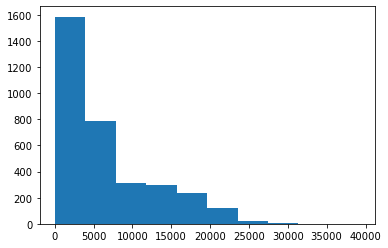

In [14]:
plt.hist(np.array(their_sp[1:]).sum(1))

(array([  3.,  15., 308., 278., 246., 235., 201., 190., 159., 110., 115.,
         84.,  76.,  63.,  69.,  66.,  56.,  57.,  55.,  53.,  39.,  44.,
         42.,  38.,  39.,  21.,  34.,  27.,  27.,  24.,  30.,  25.,  25.,
         36.,  28.,  27.,  32.,  28.,  33.,  31.,  33.,  33.,  26.,  23.,
         25.,  16.,  23.,  24.,  15.,  19.,  18.,  21.,  19.,   9.,  11.,
          5.,  14.,   8.,   7.,  12.,   3.,   4.,   1.,   3.,   3.,   2.,
          2.,   3.,   0.,   0.,   0.,   2.,   1.,   2.,   2.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([37.0, 428.56, 820.12, 1211.68, 1603.24, 1994.8, 2386.36, 2777.92,
        3169.48, 3561.04, 3952.6, 4344.16, 4735.72, 5127.28, 5518.84,
        5910.4, 6301.96, 6693.52, 7085.08, 7476.64, 7868.2, 8259.76,
        8651.32, 9042.88, 9434.44, 9826.0, 10217.56, 10609.12, 11000.68,
        11392.24, 11783.8, 12175

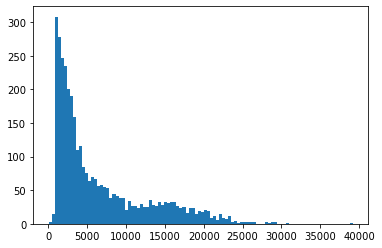

In [35]:
plt.hist(np.array(their_dp[1:]).sum(1),bins=100)

In [16]:
adata = adata1.concatenate(adata2, adata3, adata4, adata5)

In [17]:
adata.obs

,barcode,day,batch
0-0,AAAAAAAAAAAAAAAAAAA,0,0
1-0,AAAACCTCCGAAAAACATT,0,0
2-0,AAAACCTCCGATACCGGAT,0,0
3-0,AAAACCTCCGATGCCGGAT,0,0
4-0,AAAACTCGAGATAAGGCTG,0,0
...,...,...,...
1110-4,TTCGGCCTGAGCTGTCTGG,12,4
1111-4,TTCGGCCTGAGGATCTCGG,12,4
1112-4,TTCGGCCTGAGTTTAACAG,12,4
1113-4,TTGCATATGAGACTGCCGT,12,4


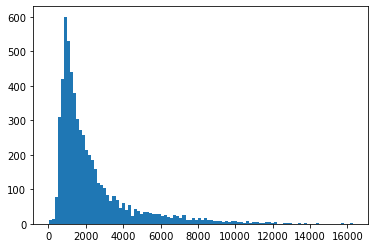

In [33]:
plt.hist(adata.X.toarray().sum(1),bins=100);

In [36]:
adata = adata[adata.X.toarray().sum(1)>1000]
adata.write_loom('./data/mESC_MN.loom')

# Load data

In [37]:
adata = sc.read('./data/mESC_MN.loom')
adata

AnnData object with n_obs × n_vars = 4444 × 55471
    obs: 'barcode', 'batch', 'day', 'obs_names'
    var: 'gene_id', 'gene_name', 'var_names'
    layers: 'matrix', 'spliced', 'unspliced'

In [38]:
adata.var_names = adata.var['gene_name']

In [39]:
clusters = adata.obs["day"]
Clusters = [0,5,11,6,12]

In [40]:
color_palette = ["#dde6d5","#fceee9","#f8d3c5","#a3b899","#667b68"]
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(Clusters))

cell_colors = np.zeros((adata.n_obs,3))

for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cell_colors[idx] = cmap_cluster(i)[:3]

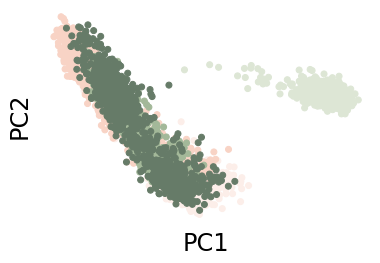

In [41]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X/total_UMI[:,None]*1000))

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],c=cell_colors);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

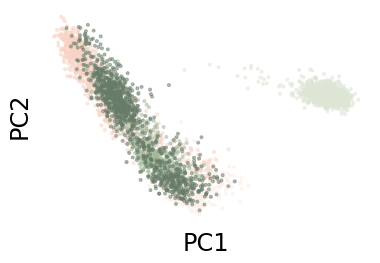

In [44]:

fig, ax = plt.subplots(1,1)
ax.scatter(x[:,0],x[:,1],marker='.',c=cell_colors,alpha=0.5);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [66]:
marker_genes = ['Smim1','Hba-x','Abcg2','Cnn3','Scube2','Klf1','Gata2','Gata2','Cd45']

# Select genes

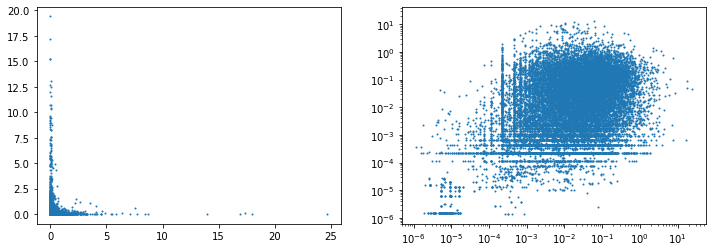

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [54]:
"""
idx = (adata.layers["unspliced"].toarray().mean(0) > 0) 
U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))


idx = adata.layers["spliced"].toarray().mean(0) > 0
S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))
"""
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X = U + S
X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total counts = 1.3415556628717462
s estimated by total counts = 0.9583432236575523


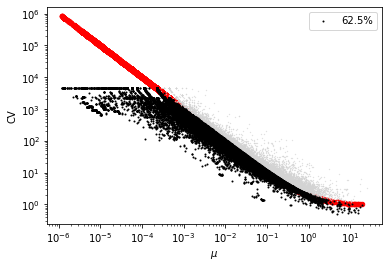

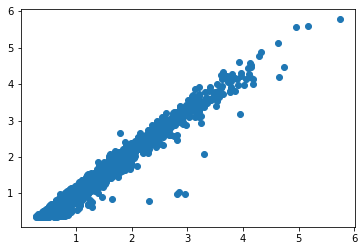

In [55]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) | (adata.layers["unspliced"].toarray().mean(0) > 0)
U=adata.layers["unspliced"][:,idx].toarray()
S=adata.layers["spliced"][:,idx].toarray()
X = U + S
X_bar = np.mean(U + S, axis=0)
X_var = np.var(U + S, axis=0)

a=1
s=s2
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

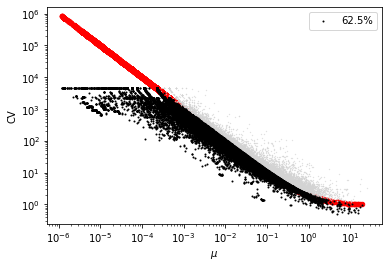

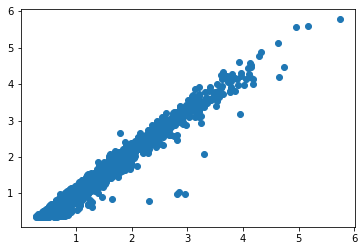

In [59]:
a=1
s=s2
Pgene_mask = (X_bar > 0) & (X_var/(a*X_bar + s*X_bar**2) < 1.1)
Pgenes = adata.var_names[idx][Pgene_mask]

plt.scatter(X_bar[Pgene_mask], a/X_bar[Pgene_mask] + s, c='r', s=20)
plt.scatter(X_bar, X_var/X_bar**2,c='lightgray',alpha=1, s=0.1)
plt.scatter(X_bar[Pgene_mask], X_var[Pgene_mask]/X_bar[Pgene_mask]**2,c='k', s=1, label=str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%")
plt.xlabel(r'$\mu$')
plt.ylabel(r'CV')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc="upper right")

read_depth =  (U + S)[:,Pgene_mask].sum(1)
rd = read_depth/read_depth.mean()

plt.figure()
plt.scatter(rd,adata.X.toarray().mean(1)/adata.X.toarray().mean())

(4444, 301, 2)

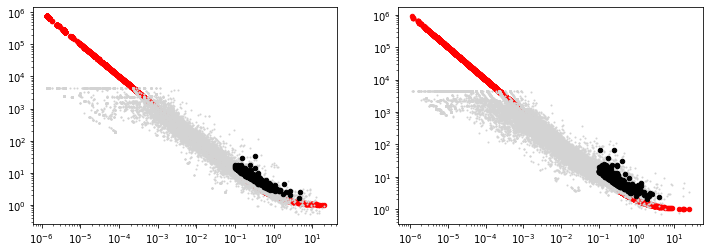

In [64]:
var_threshold = 1.3
a=1

U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.1) & (S_mean > 0.1) \
    & (np.abs(np.log(S_mean/U_mean)) < 4) \
    & (U_var/(a*U_mean + s2*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + s2*S_mean**2) > var_threshold)

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(S_mean, a/S_mean + s2, c='r', s=20)
ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=1)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, c='k', s=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(U_mean, a/U_mean + s2, c='r', s=20)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=1)
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, c='k', s=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

X=np.zeros((n,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
X.shape

In [67]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index([], dtype='object', name='gene_name')


In [68]:
plot_idx = np.arange(10)

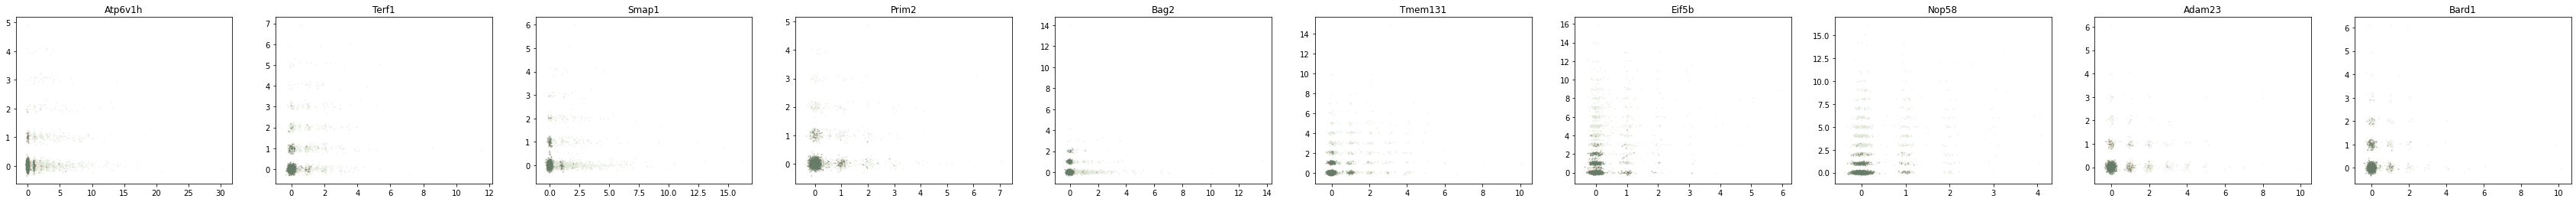

In [70]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),\
                  X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),\
                  c=cell_colors,s=0.5,alpha=0.5)

# Mixtures fitting

In [71]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

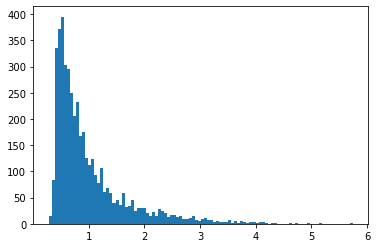

In [76]:
plt.hist(rd,bins=100);

In [73]:
PMs = []
for nc in range(2,7):
    PM = PoissonMixture(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    print(nc,PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

2 nan nan
3 nan nan
4 nan nan
5 nan nan
6 nan nan


In [77]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=10,n_init=5)
PM.weights

array([nan, nan, nan])

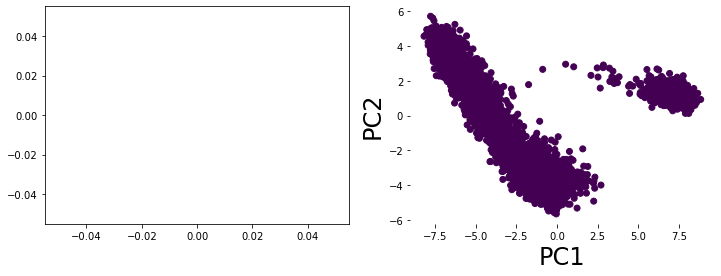

In [78]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters[cell_idx])],'.');
ax[1].scatter(x[cell_idx,0],x[cell_idx,1],c=np.argmax(Q,axis=1));
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

Text(0.5, 1.0, 'intercept test p value')

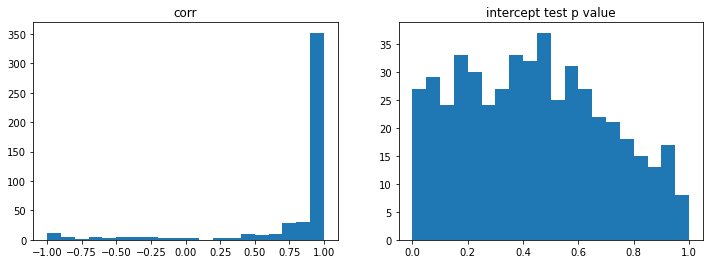

In [331]:
slope, intercept, corr, pval = linear_regression(GPM.theta)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(corr,bins=np.linspace(-1,1,21))
ax[0].set_title('corr')
ax[1].hist(pval,bins=np.linspace(0,1,21))
ax[1].set_title('intercept test p value')

# Trajectory fitting

In [109]:
elbos = {}
params={'r':rd,"lambda_tau":0,"lambda_a":0}

## Fine cluster

In [296]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

In [297]:
topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=10,epoch=100)
print(traj.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [08:36<00:00,  5.17s/it]


-658.3186044861851


[ 0.         23.92821688 48.        ]


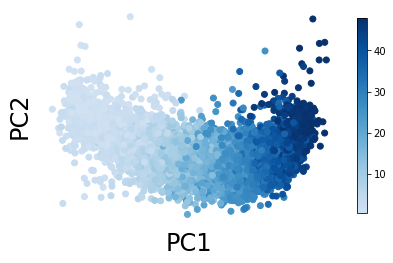

In [298]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

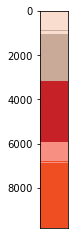

In [188]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

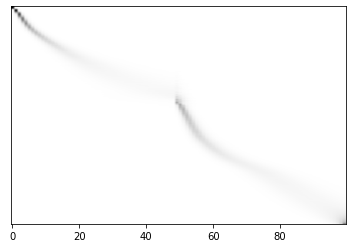

In [189]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj,l=0,ax=ax,order_cells=True)
ax.set_yticks([]);

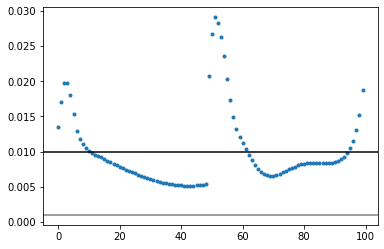

In [190]:
plt.plot(traj.Q[:,0].mean(0),'.')
plt.axhline(y=1/traj.m,c='k')
plt.axhline(y=0.1/traj.m,c='gray')

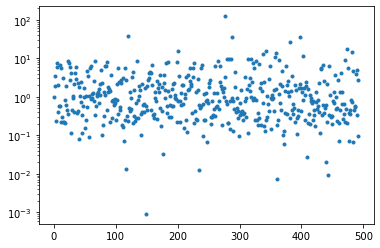

In [191]:
plt.plot(traj.theta[:,[-2]],'.')
plt.yscale('log')

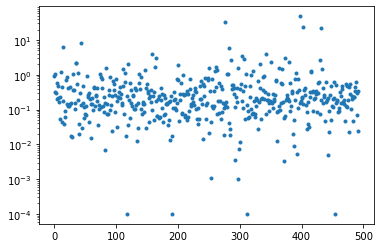

In [192]:
plt.plot(traj.theta[:,[-1]],'.')
plt.yscale('log')

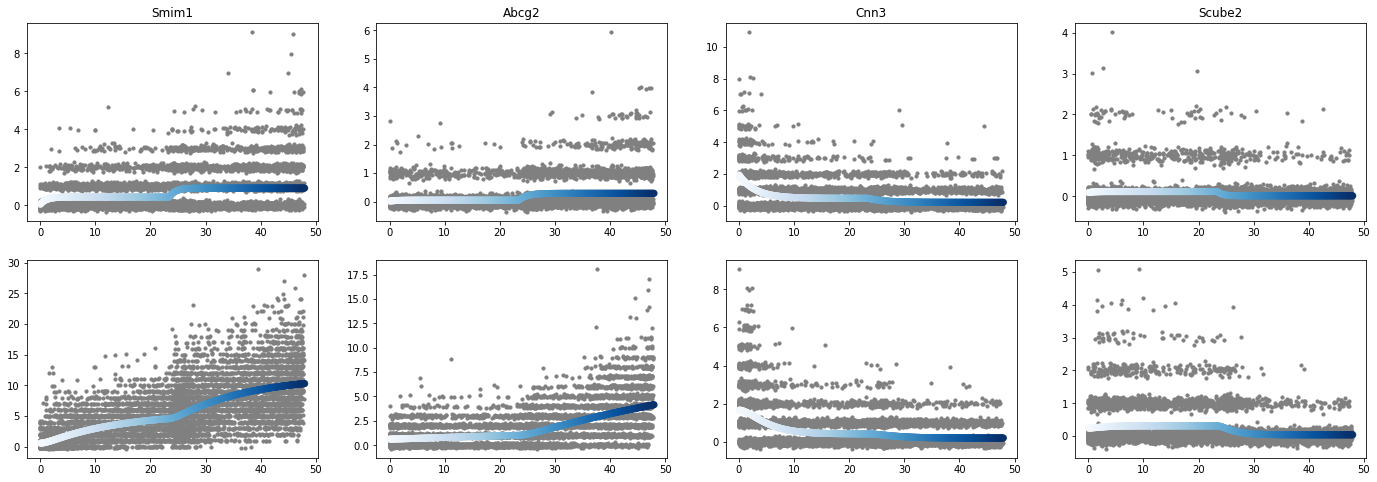

In [193]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

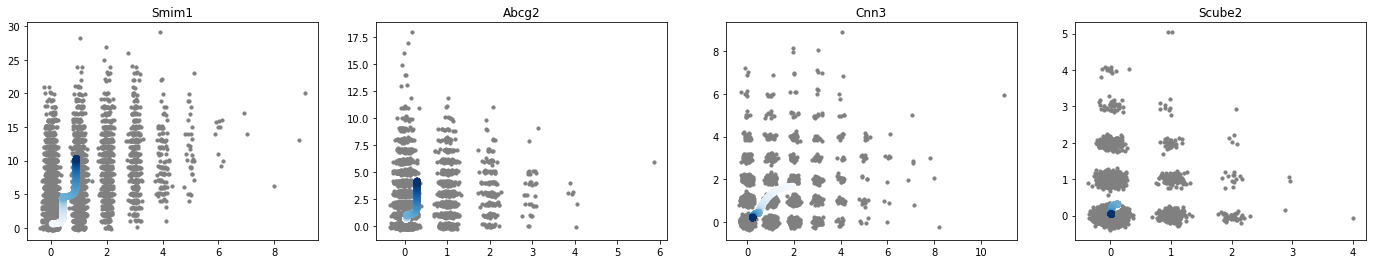

In [194]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

36


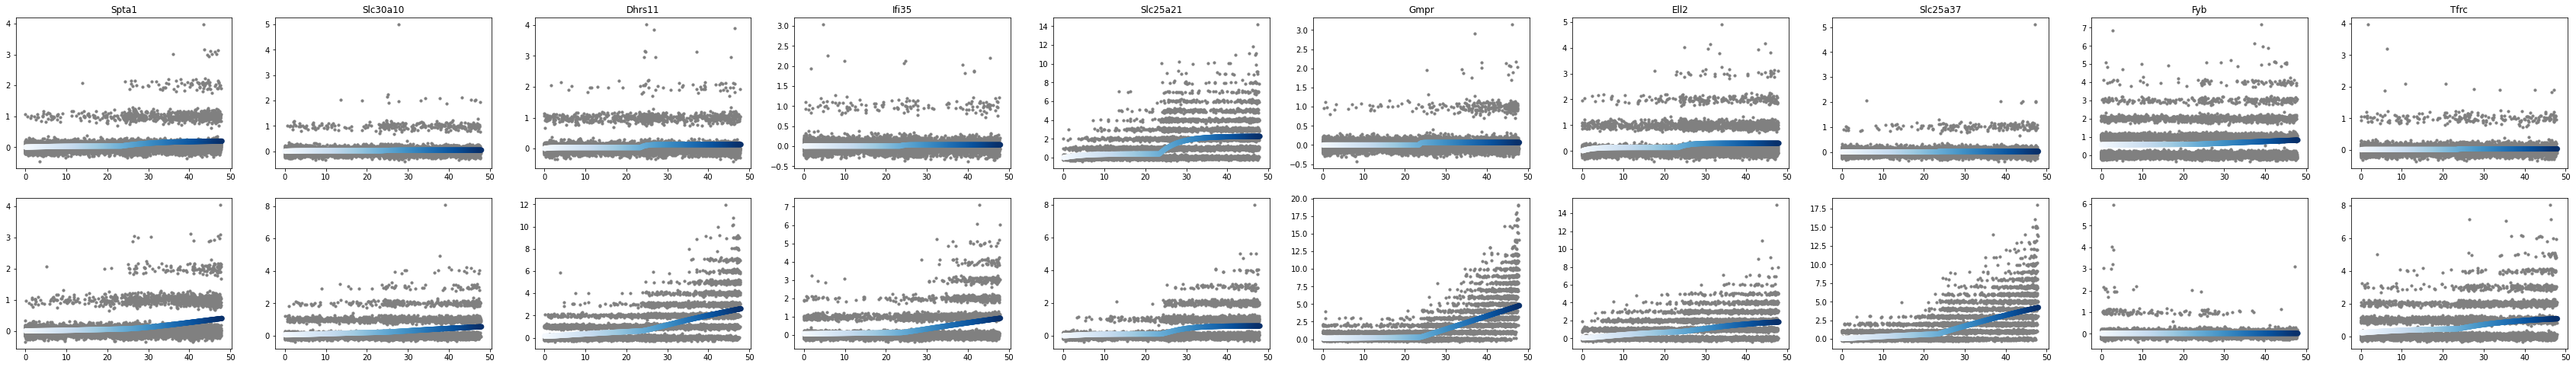

In [195]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

In [196]:
plot_marker_genes = ['Gata1','Gata2','Hba-x']

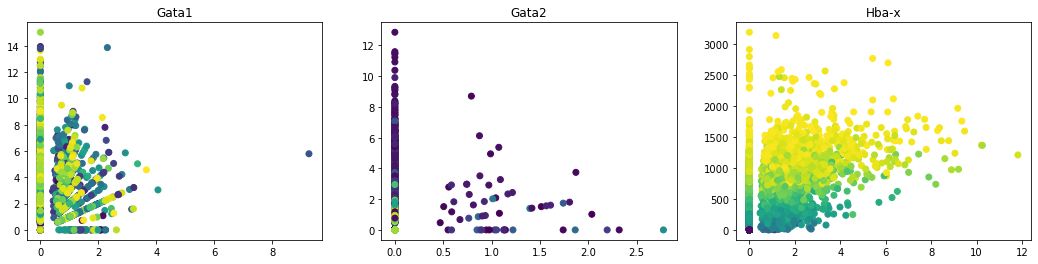

In [197]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

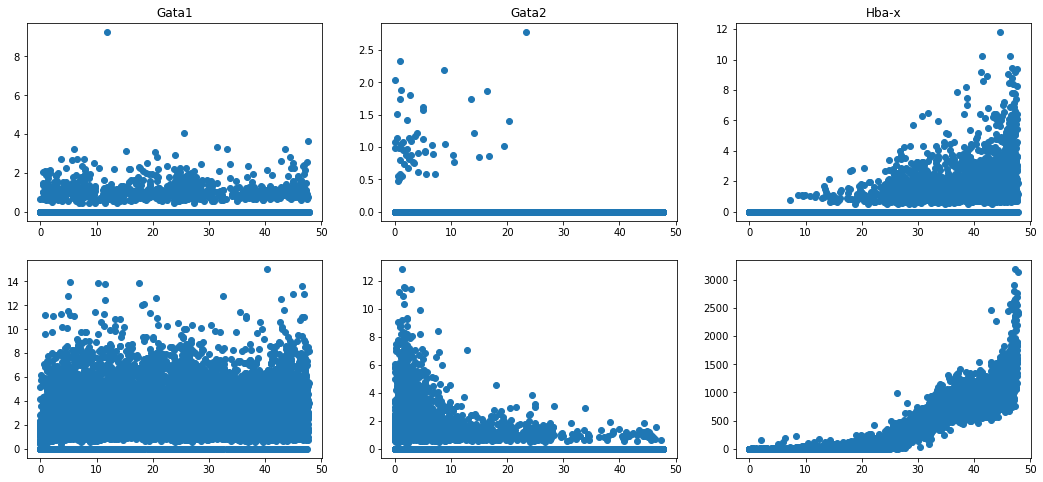

In [198]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

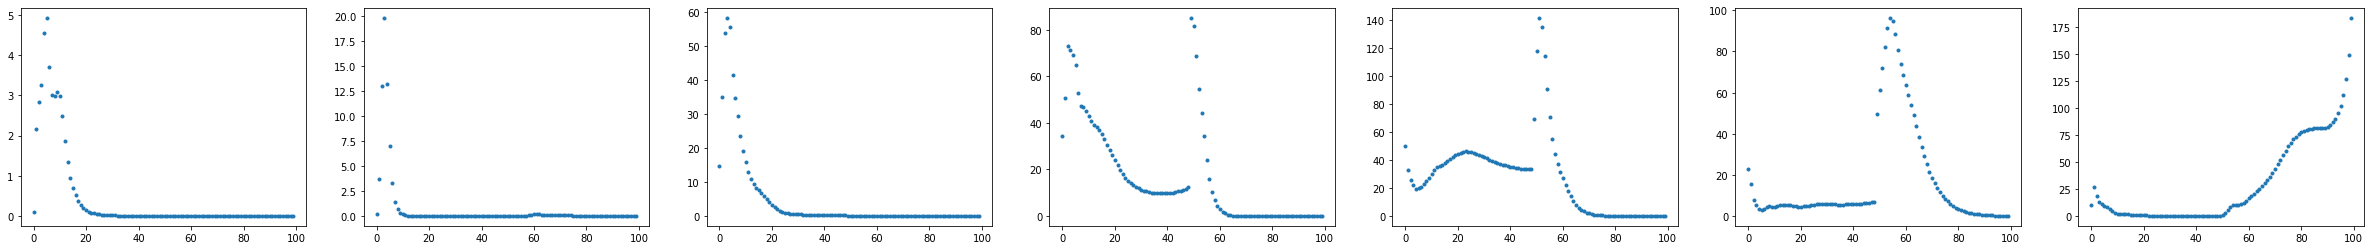

In [199]:
fig, ax = plt.subplots(1,len(stages),figsize=(6*len(stages),4))
for i,stage in enumerate(stages):
    idx = adata.obs["stage"].isin([stage])
    ax[i].plot(traj.Q[idx,0].sum(0),'.')

[Text(0, 0, 'α0'), Text(1, 0, 'α1'), Text(2, 0, 'α2')]

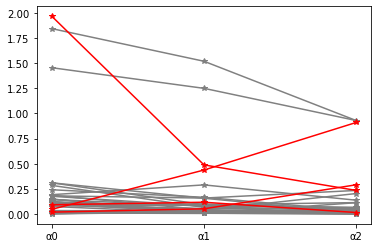

In [201]:
p=30
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[0,1,2]],'-*',color='red')

x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
#plt.yscale('log')

In [ ]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Fitting without prior

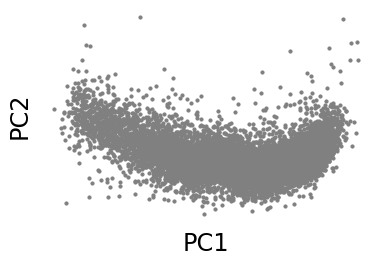

In [202]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [260]:
tau = (0,23.43,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [1:08:43<00:00, 41.23s/it]


Text(0.5, 1.0, 'Random initialiazation')

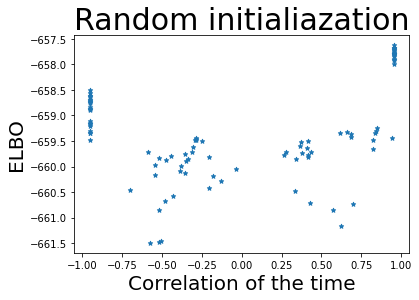

In [270]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [271]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [1:58:16<00:00, 70.96s/it] 


Text(0.5, 1.0, 'Random initialiazation')

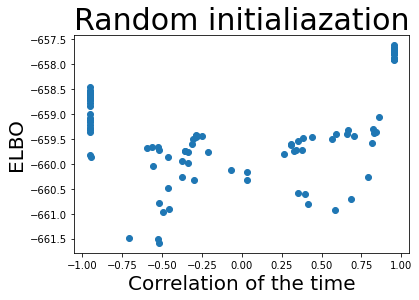

In [272]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [280]:
traj = trajs[np.argmax(elbos)]
np.max(elbos)

-657.6270520051801

[ 0.        23.5483401 48.       ]


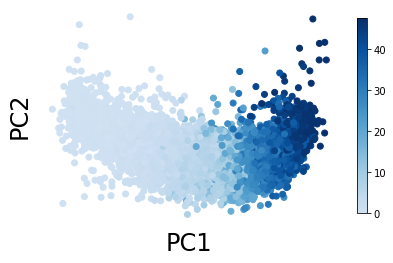

In [274]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

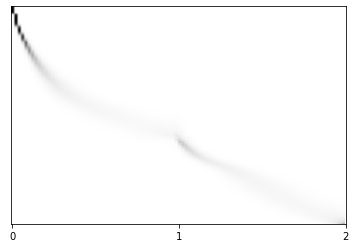

In [275]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

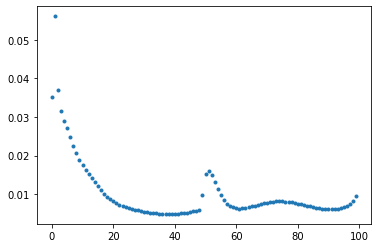

In [276]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.')

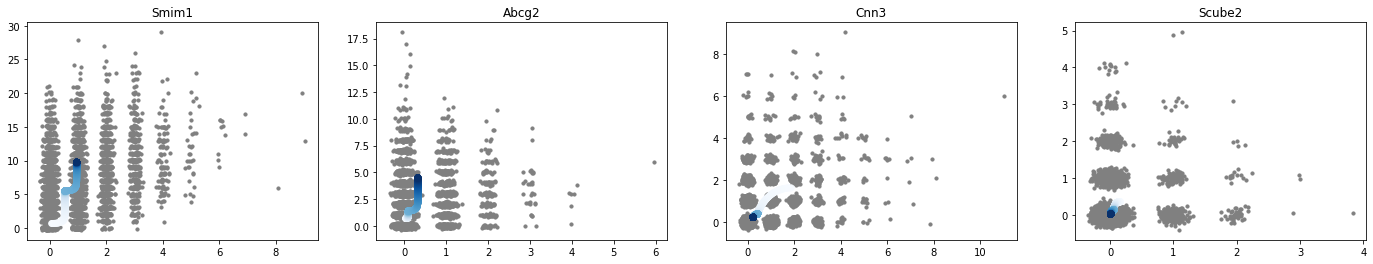

In [277]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

29


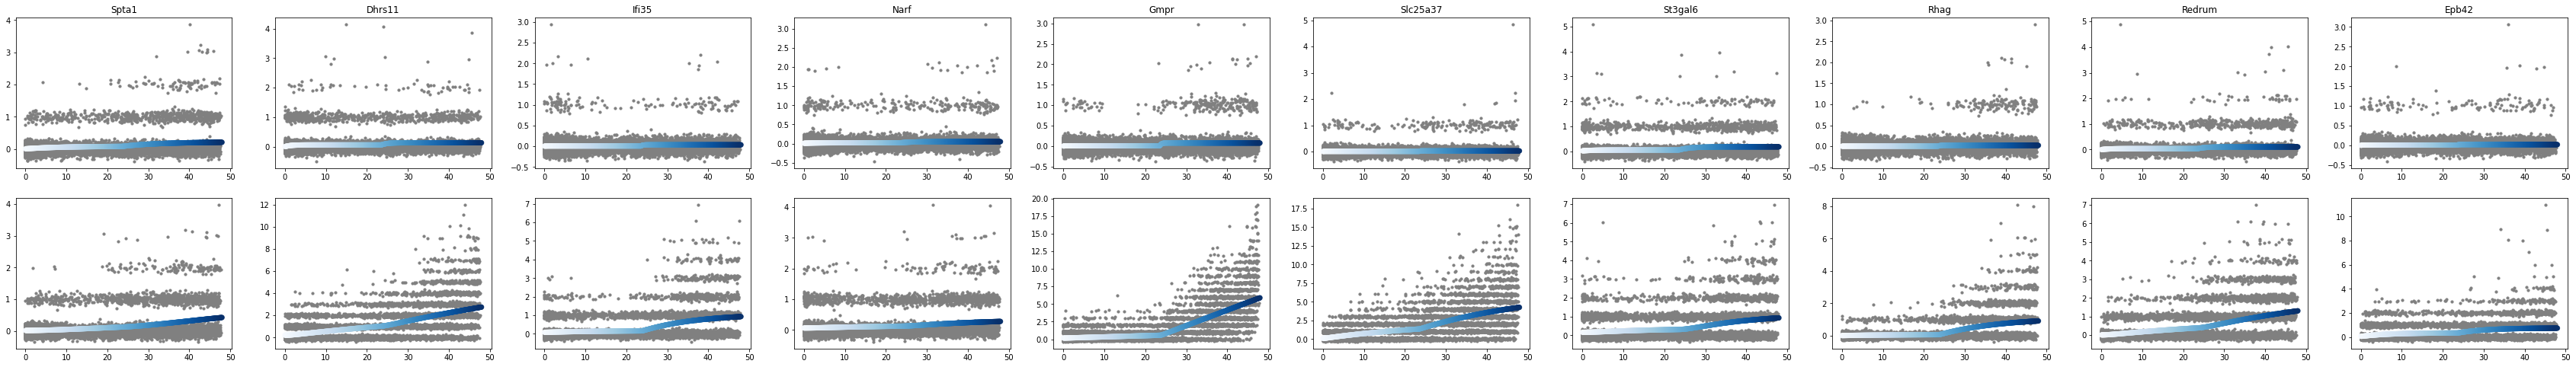

In [278]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);

### two_species_ss_tau

In [228]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(20)):
    traj = Trajectory(topo, tau,  model="two_species_ss_tau", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 20/20 [20:21<00:00, 61.06s/it]


Text(0.5, 1.0, 'Random initialiazation')

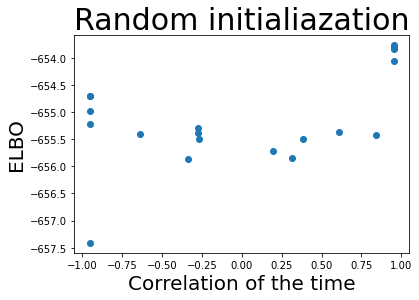

In [229]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [235]:
traj = trajs[np.argmax(elbos)]

(array([171.,   4.,  17.,  12.,  18.,  34.,   9.,  23.,   9., 196.]),
 array([23.5, 23.6, 23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5]),
 <BarContainer object of 10 artists>)

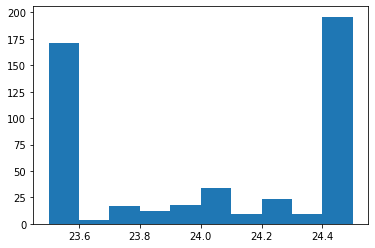

In [236]:
plt.hist(traj.theta[:,-3])

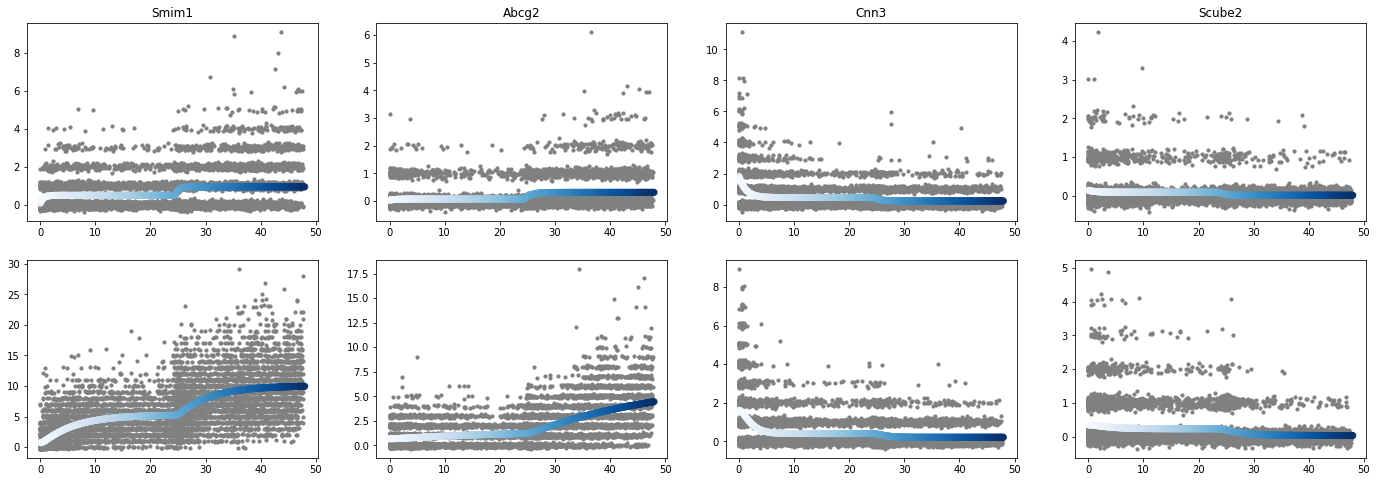

In [237]:
plot_y(traj,idx=plot_idx,gene_name=fitted_genes);

### two_species

In [242]:
tau = (0,24,48)
topo = np.array([[0,1,2]])
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, fit_tau=True, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [2:02:24<00:00, 73.45s/it] 


Text(0.5, 1.0, 'Random initialiazation')

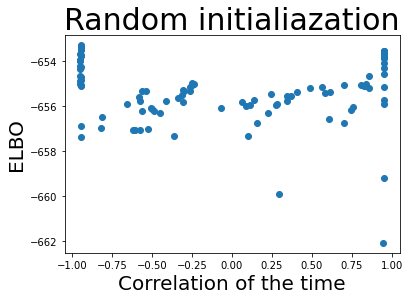

In [243]:
corrs = []
elbos = []
for traj in trajs:
    right_t = Q0[:,0] @ traj.t
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

In [257]:
traj = trajs[np.argmax(elbos)]
traj.elbos[0][-1]

-653.2902129127483

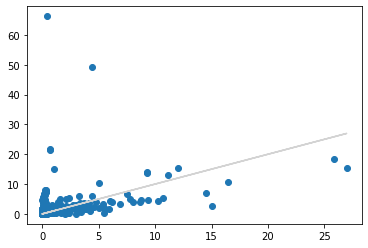

In [258]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

In [259]:
traj = trajs[np.argmax(corrs)]
traj.elbos[0][-1]

-654.0742261573195

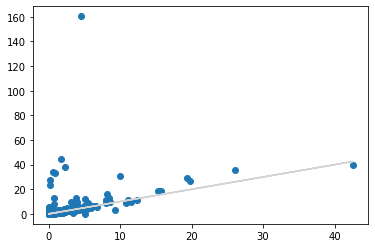

In [256]:
plt.scatter(traj.theta[:,-3],traj.theta[:,0]*traj.theta[:,-2]/traj.theta[:,-1])
plt.plot(traj.theta[:,-3],traj.theta[:,-3],color="lightgray")

# Synthetic data

In [299]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

topo = np.array([[0,1,2]])
tau = (0,24,48) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=params,Q=Q0,parallel=True,n_threads=4,epoch=10)

fitting with warm start


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]


In [301]:
print(traj.elbos[-1])

-658.4752472018502


[ 0.         23.94425778 48.        ]


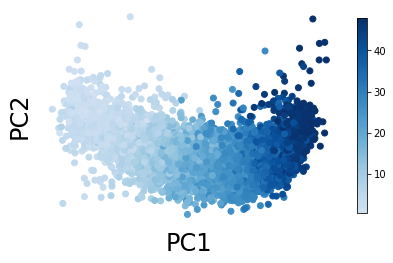

In [300]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

<AxesSubplot:>

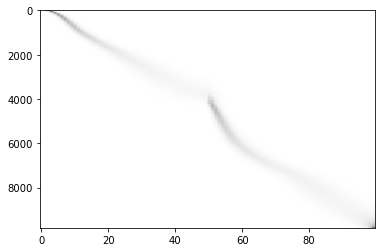

In [302]:
plot_t(traj,order_cells=True)

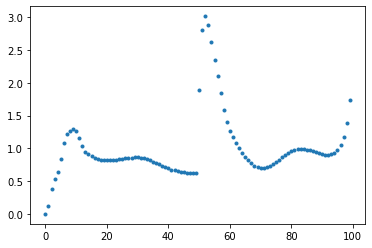

In [303]:
plt.plot(traj.Q.sum((0,1))/traj.Q.sum()*traj.m,'.')

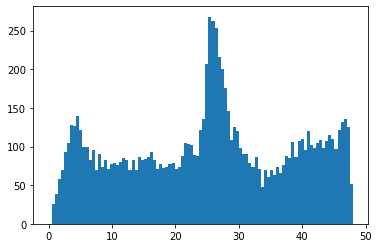

In [304]:
Y = traj.get_Y_hat(theta=traj.theta,t=traj.Q[:,0]@traj.t,tau=traj.tau,topo=traj.topo,params=traj.params)
syn_X = np.random.poisson(rd[:,None,None]*Y[0])
syn_t = traj.Q[:,0]@traj.t
plt.hist(syn_t,bins=traj.t);

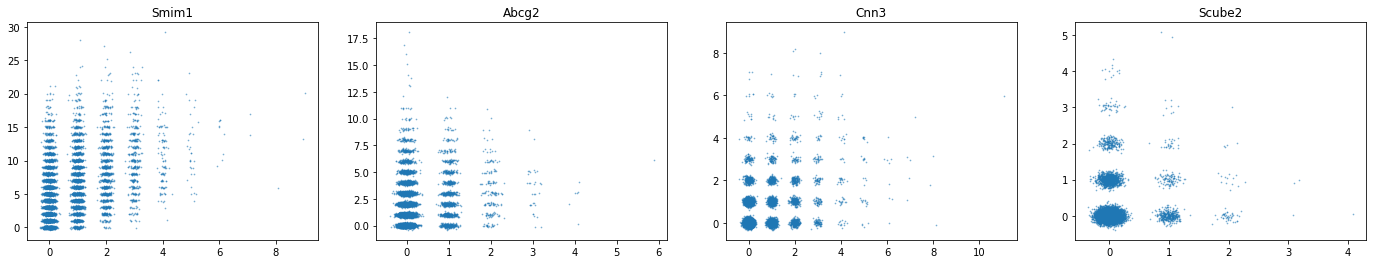

In [307]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

In [309]:
syn_tau = traj.tau.copy()
syn_topo = traj.topo.copy()
trajs = []
for seed in tqdm(range(20)):
    syn_traj = Trajectory(syn_topo, syn_tau,  model="two_species_ss", restrictions={}, verbose=0)
    syn_traj = syn_traj.fit(syn_X, warm_start=False, fit_tau=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=4, seed=seed)
    trajs.append(syn_traj)

100%|██████████| 20/20 [12:44<00:00, 38.21s/it]


Text(0.5, 1.0, 'Random initialiazation')

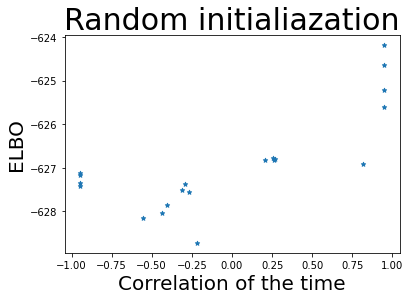

In [310]:
corrs = []
elbos = []
for syn_traj in trajs:
    right_t = syn_t
    t_hat = syn_traj.Q[:,0] @ syn_traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( syn_traj.elbos[np.argmax([syn_traj.elbos[i][-1] for i in range(len(syn_traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)